# Week of 2025.2.10 

## 1. Add default/manual override viscosity to frictional source term
The first thing I did this week was modify the frictional source term to allow for a default viscosity to be specified. I merged [this](https://github.com/fredriclam/quail_volcano/pull/21) PR into master.

Let's test that behavior out. 

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Modify base path for depending on your file structure.
BASE_PATH = "/Users/paxton/git"

# Specify path where .pkl files are located
target_dir = f"{BASE_PATH}/quail_volcano/scenarios/simple_1D_test"
# Specify path for Quail source code
source_dir = f"{BASE_PATH}/quail_volcano/src"
# Change to working directory
os.chdir(target_dir)


# Import quail modules
os.chdir(source_dir)

import meshing.tools as mesh_tools

import numerics.helpers.helpers as helpers
import numerics.timestepping.tools as stepper_tools

import physics.zerodimensional.zerodimensional as zerod
import physics.euler.euler as euler
import physics.navierstokes.navierstokes as navierstokes
import physics.scalar.scalar as scalar
import physics.chemistry.chemistry as chemistry
import physics.multiphasevpT.multiphasevpT as multiphasevpT

import processing.readwritedatafiles as readwritedatafiles
import processing.post as post
import processing.plot as plot
import processing.animate as animate

import solver.DG as DG
import solver.ADERDG as ADERDG
import solver.tools as solver_tools

import time
from IPython.display import HTML
import multiprocessing as mp  
from multidomain import Domain, Observer

os.chdir(target_dir)

I played around with the parameters below, and proved to myself that I am able to set viscosity with my new parameter. 

## 2. Update velocity calculation

In playing with various parameters, I need to update the calculation for expected velocity.

We recall from a [previous week](https://paxtonsc.github.io/files/geophysics/2025.1.28.experiments.html) that velocity can be calculated with

$$
\begin{align}
0 &= \frac{P_L - P_0}{L} - \frac{8\mu u}{R^2} \\

u &= \frac{P_L - P_0}{L} \frac{R^2}{8 \mu}
\end{align}
$$

In [1]:
from astropy import units as u

# the viscosity is calculated from the numerical simulation. 
mu = 4.7 * 1e5 * u.Pa * u.s
R = 50 * u.m
L = 1000 * u.m
P_0 = 1 * u.MPa
P_l = 10 * u.MPa

u_steady_state = ((P_l - P_0)/L) * (R**2 / (8*mu))

print(f"The predicted velocity of the steady state solution: {u_steady_state.to(u.m/u.s)}")

The predicted velocity of the steady state solution: 5.984042553191489 m / s


# 3. Update characteristics from last week

[Last week](https://paxtonsc.github.io/files/geophysics/2025.2.5.experiments.html) it was a little tricky to see if the initial conditions truly propagated along the characteristics curves because of:
1. There was a lot of diffusion due to numerical error. 
2. The velocity was minimal, so the characteristic lines was almost vertical. 

Now our velocity is slightly faster and I will increase the spatial and temporal resolution to attempt to get a cleaner line. 

t_steps = 20,000
space_steps = 1,000

In [ ]:
def plot_characteristics(folder, file_prefix, u=2, N_m = 200, N_t = 100, T_end = 20, X_start=-1000):

    X = np.zeros((N_t, N_m)) 
    F = np.zeros((N_t, N_m)) 

    for i in range(0, N_t):
        solver = readwritedatafiles.read_data_file(f"{folder}/{file_prefix}_{i}.pkl")
        physics = solver.physics
        slip = solver.state_coeffs[:,:,solver.physics.get_state_index("slip")]
        f, _, = physics.get_conv_flux_interior(solver.state_coeffs)

        X[i, :] = slip.ravel()
        F[i, :] = f[:,0,8,0].ravel()


    fig, ax = plt.subplots(figsize=(6,6))
    im = ax.imshow(X, extent=[-1000, 0, T_end, 0], aspect='auto')

    fig.colorbar(im)

    # Plot the charecteristics we expect the solution to be constant along. 
    plt.axline((-1000, 0), slope=1/u, color="black", linestyle=(0, (5, 5)))
    plt.axline((-800, 0), slope=1/u, color="black", linestyle=(0, (5, 5)))
    plt.axline((-600, 0), slope=1/u, color="black", linestyle=(0, (5, 5)))
    plt.axline((-400, 0), slope=1/u, color="black", linestyle=(0, (5, 5)))
    plt.axline((-200, 0), slope=1/u, color="black", linestyle=(0, (5, 5)))

    ax.set_ylabel('Time (s)')
    ax.set_xlabel('Position (m)')
    ax.invert_yaxis()
    ax.set_title("New state variable (pDensityX) over time and space")

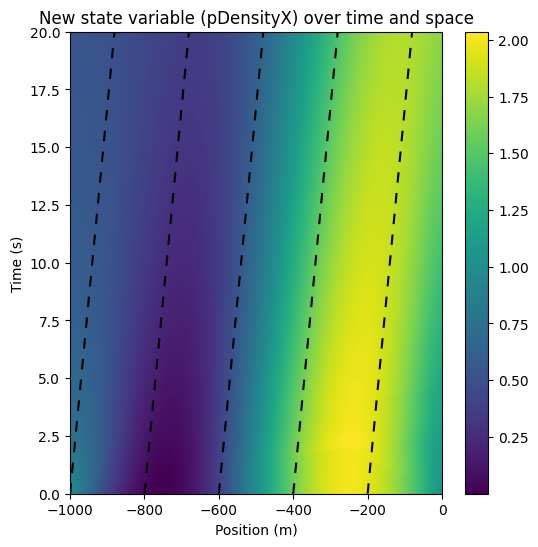

In [24]:
folder = "slip_variable_addition"
file_prefix = "test_output_high_def"

plot_characteristics(folder, file_prefix, u=5.98, N_m=1000, N_t=200)

The characteristic graph is still a little hard to parse. Below I plot the quantity `arhoX` at t=0 and t=10 and compare the minimum and maximum point of each curve.

We see that over 20 seconds, the lowest and highest point progress roughly the expected 120m.

$$120 [m] = 5.98 [m/s] * 20 [s]$$

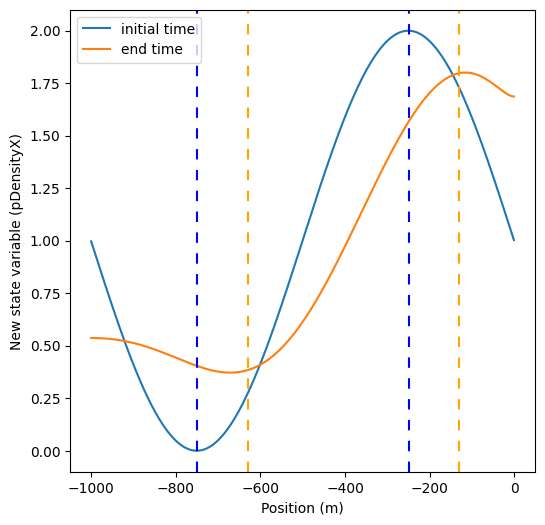

In [ ]:
solver = readwritedatafiles.read_data_file(f"{folder}/{file_prefix}_{0}.pkl")
slip_0 = solver.state_coeffs[:,:,solver.physics.get_state_index("slip")]

solver = readwritedatafiles.read_data_file(f"{folder}/{file_prefix}_{200}.pkl")
archoX_Nt = solver.state_coeffs[:,:,solver.physics.get_state_index("slip")]

# Get the position of of each nodal points (location corresponding to each entry of pDensityX)
nodal_pts = solver.basis.get_nodes(solver.order)
# Allocate [ne] x [nb, ndims]
x = np.empty((solver.mesh.num_elems,) + nodal_pts.shape)

fig, ax = plt.subplots(figsize=(6,6))
ax.plot(np.arange(-1000, 0), slip_0.ravel(), label="initial time")
ax.plot(np.arange(-1000, 0), archoX_Nt.ravel(), label="end time")

u = 5.98 # m/s
delta_in_x = u * 20

ax.axline((-750,0), (-750, 1), color="blue", linestyle=(0, (5, 5)))
ax.axline((-750 + delta_in_x,0), (-750 + delta_in_x, 1), color="orange", linestyle=(0, (5, 5)))
#
ax.axline((-250,0), (-250, 1), color="blue", linestyle=(0, (5, 5)))
ax.axline((-250 + delta_in_x,0), (-250 + delta_in_x, 1), color="orange", linestyle=(0, (5, 5)))
ax.legend()

ax.set_ylabel('New state variable (pDensityX)')
ax.set_xlabel('Position (m)')
plt.show()

# 4. Doing the science

Okay, now that we have cleaned up the results of the previous week, lets review what Eric and I discussed during our meeting last week. 


## 4.1 What is `arhoX`? 

`arhoX` is the partial density of the new variable $X$ where partial density is expressed as:

$$\rho_i \alpha_i = \rho y_i$$

Where $\rho_i$ is the phasic density of the phase i, $\rho$ is the mixture density, $\alpha_i$ is the volume fraction, and $y_i$ is the mass fraction of phase i. 

For our notation, we have been using `q` to refer to the mass fraction of the new variable. The conservation equation we are solving is:

$$ \frac{\partial (\rho q)}{\partial x} + u \frac{\partial (\rho q)}{\partial t} = \rho S$$


## 4.2 Applying the new variable to slip

Lets define $s(X, t)$ as the split of material element at t, X. 

The material derivative operator will be defined as 

$$\frac{D s}{Dt} = \frac{\partial S}{\partial t} + u \frac{\partial s}{\partial x}$$

rewriting that equation in conservation from we get:

$$ \frac{ \partial (\rho S)}{\partial t} + \frac{\partial (\rho s u)}{\partial x} = \rho u$$


## 4.3 Numerical simulation. 

As a preliminary start, I simply modified my source term for the new state variable to have the source be $\rho u$. 

Below are the results. 




In [4]:
ani = animate.animate_conduit_pressure("slip_variable_addition", iterations=100, file_prefix="test_output")

HTML(ani.to_html5_video())

/Users/paxton/git/quail_volcano/scenarios/simple_1D_test


## 4.4 Slip -> sheer stress -> volumetric force

Our purpose of calculating slip is to calculate a shear stress as a function of that slip. Eric recomended two mappings $\tau{S}$. 

First
$$
\begin{align}
\tau &= \tau_p - (\tau_p - \tau_r) \frac{S}{DC} & 0 < S < D_c \\
\tau & = \tau_r & S > D_c
\end{align}
$$

and second 
$$
\begin{align}
\tau = \tau_r + (\tau_p - \tau_r) e^{-S/D_c}
\end{align}
$$

where 

$\tau_p $ - peak strength 

$\tau_r$ - residual strength 

$D_c$ - slip weakening distance


To calculate volumetric drag from shear stress is just:

$$
\begin{align}
F_{vd} = \frac{\tau * 2 \pi r *l}{\pi r^2 * l } = \frac{2}{r} \tau
\end{align}
$$


$$
M = - F_{vol} \\
E = - F_{vol} * u
$$

## 4.5 Numerical simulation with volumetric drag from slip

Let's figure out what velocity we expect now that we have an additional volumetric friction term. For steady state, constant velocity conservation of momentum tells us:

$$
0 = - \frac{\partial p}{\partial x} - \frac{2 \tau_{visc}}{r} - \frac{2 \tau_{slip}}{R} 

$$
and
$$
- \frac{\partial p}{\partial x} = \frac{P_l - P_0}{L} 
$$


That becomes 

$$
u = \frac{R^2}{8 \mu}(\frac{P_l - P_0}{L} - \frac{2 \tau_{slip}}{R})
$$

If we then plug in $R_L = 10 [ M Pa]$, $R_0 = 1 [M Pa]$, $L=1000 [m]$, $\tau_{slip}= 1e5 [Pa]$, and $R=50 [m]$ we get the following speed:


In [9]:
R_l = 10 * u.MPa
R_0 = 1 * u.MPa

L = 1000 * u.m
tau_slip = 1e5 * u.Pa
R = 50 * u.m

mu = 0.5 * u.MPa * u.s

print(f" The expected velocity is { R**2 / (8 * mu) * ((P_l -P_0)/L - 2 * tau_slip/R)}")


 The expected velocity is 3.1249999999999996 m / s


Which is indeed the velocity we calculate. 

In [3]:
ani = animate.animate_conduit_pressure("slip_variable_addition", iterations=100, file_prefix="test_slip_friction")

HTML(ani.to_html5_video())

/Users/paxton/git/quail_volcano/scenarios/simple_1D_test


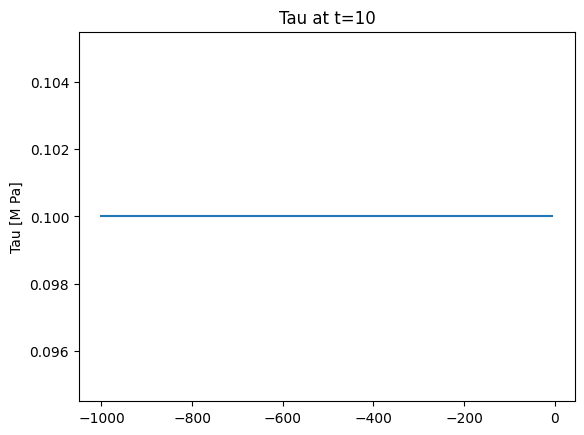

In [10]:
folder="slip_variable_addition"
file_prefix="test_slip_friction"

solver = readwritedatafiles.read_data_file(f"{folder}/{file_prefix}_{50}.pkl")
fsource = solver.physics.source_terms[2]
tau = fsource.compute_tau(solver.state_coeffs, solver.physics)

plt.title("Tau at t=10")
plt.ylabel("Tau [M Pa]")
plt.plot(np.arange(-1000, 0, 5), tau.ravel()/1e6)

## 4.6 More general case when $\tau_p > \tau_r$

$$
u = \frac{R^2}{8 \mu}(\frac{P_l - P_0}{L} - \frac{2 \tau_{slip}}{R})
$$

The function for $\tau_{slip}$ is no longer a constant but rather

$$
\begin{align}
\tau_{slip} = \tau_r + (\tau_p - \tau_r) e^{-S/D_c}
\end{align}
$$

To verify that our numerical solution is working correctly, I wrote an analytical function like so

```
tau = 5e4 + (2e5 - 5e4)*np.exp(-slip/10)
analytical_velocity = (50**2 / 8 * viscosity) * ((10e6 - 1e6) / 1000 - 2 *tau / 50)
```

to compare the numerical solution to. 


In [3]:
ani = animate.animate_conduit_pressure("slip_variable_addition", iterations=100, file_prefix="test_variable_tau")

HTML(ani.to_html5_video())

/Users/paxton/git/quail_volcano/scenarios/simple_1D_test


## 4.5 Open questions 

1. The source term $ \rho u$ has units of $kg / (s * m^2)$. What is the best way to think about that quantity? Momentum per unit volume? 

2. At the moment, the "slip" is basically equvivalent to our velocity * time. That makes sense to me. But I want to sanity check that with Eric. 
